In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import sympy 
from sympy import banded, ones, Matrix, symbols, sqrt, print_latex, oo
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import wofz 
import pickle

In [3]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Asymmetrically Weighted Hermite Linear Response Function w/ Hypercollisionality

In [4]:
# number of moments
Nv = 4

In [5]:
# symbolic variables
xi = symbols('xi') 
nu = symbols('nu', real = True) # must be real and not complex
k = symbols('k', integer = True) # must be an integer from defintion

In [6]:
# advection matrix (off-diagonal)
vec = sympy.zeros(Nv)
for jj in range(1, Nv+1):
    vec[jj-1] = sympy.sqrt(jj)/ (sympy.sqrt(2))

In [7]:
# advection matrix (main-diagonal)
vec2 = sympy.zeros(Nv)
for jj in range(0, Nv+1):
    # hyper collisions coefficient
    vec2[jj] = sympy.Rational((jj)*(jj-1)*(jj-2), (Nv-1)*(Nv-2)*(Nv-3))

In [8]:
# enforce k=1 for simplicity now
k=1

In [9]:
# create an advection tri-diagonal matrix
A = banded({1: tuple(vec[0, :-1]), -1: tuple(vec[0, :-1]), 0: tuple(nu*vec2[0, :]/(sympy.I*sympy.sqrt(2)*k))})

In [10]:
A

Matrix([
[        0, sqrt(2)/2,         0,               0],
[sqrt(2)/2,         0,         1,               0],
[        0,         1,         0,       sqrt(6)/2],
[        0,         0, sqrt(6)/2, -sqrt(2)*I*nu/2]])

In [11]:
# idenitity matrix
I = np.eye(Nv, dtype=int)

In [12]:
# invert matrix
M = sympy.Matrix(I*xi - k/ np.abs(k) * A)

In [13]:
# get final response function 
R_approx = sympy.simplify(sympy.simplify(M.inv()[0, 1]/sympy.sqrt(2) * k / np.abs(k)))

In [14]:
# print 
# R_approx

In [15]:
# latex code
# print_latex(R_approx)

## Asymptotic Expansion

### Adiabatic limit $\xi \to 0$

In [16]:
asymptotics_0 = R_approx.series(xi, 0, 2)

In [17]:
asymptotics_0

-1 - 2*sqrt(2)*I*nu*xi/3 + O(xi**2)

In [18]:
sympy.simplify(asymptotics_0.coeff(xi, 0))

-1

In [19]:
sympy.simplify(asymptotics_0.coeff(xi, 1))

-2*sqrt(2)*I*nu/3

In [20]:
func = sympy.lambdify(nu, asymptotics_0.coeff(xi, 1) + sympy.I*sympy.sqrt(sympy.pi), modules='numpy')

In [21]:
sol_coeff = scipy.optimize.newton(func, x0=1, maxiter=20000, rtol=1e-3, full_output=True)

In [22]:
sol_coeff

((1.8799712059732503+0j),
       converged: True
            flag: converged
  function_calls: 3
      iterations: 2
            root: (1.8799712059732503+0j)
          method: secant)

In [23]:
print("first coeff error = ", func(sol_coeff[0]))

first coeff error =  0j


In [24]:
# save optimal nu (for k=1)
with open("optimal_nu_hyper/nu_" + str(Nv) + ".txt", "wb") as outf:
    pickle.dump(sol_coeff[0], outf)

In [25]:
# save optimal R(nu*) (for k=1)
with open("optimal_R_hyper/R_" + str(Nv) + ".txt", "wb") as outf:
    pickle.dump(sympy.simplify(R_approx.subs(nu, sol_coeff[0].real)), outf)

In [26]:
def optimal_nu4(k):
    return (3*np.sqrt(2*np.pi) * (k**2)) / (6*k -2*np.abs(k))

def optimal_nu5(k):
    return -(3*np.sqrt(2*np.pi) * (k**2)) / (4*k -6*np.abs(k)) - np.sqrt(2)*1j*np.sqrt(-9*np.pi*(k**4) + 236*(k**4) -204*(k**3)*np.abs(k))/(4*k - 6*np.abs(k))

In [27]:
# fig, ax = plt.subplots(figsize=(6, 3))
# ax.plot(10**np.linspace(0, 1, 1000), optimal_nu4(10**np.linspace(0, 1, 1000)), c="blue", linewidth=3, label=r"$N_{v}=4$")
# ax.plot(10**np.linspace(0, 1, 1000), optimal_nu5(10**np.linspace(0, 1, 1000)).real, c="red", linewidth=3,  label=r"$N_{v}=5$")
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set_xlabel(r"$k$")
# ax.set_ylabel(r"$\nu^{*}(k)$")
# legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper left')
# legend.get_frame().set_alpha(0)
# plt.tight_layout()
# plt.savefig("figs/optimal_collisons.png", dpi=200)

### Fluid (cold plasma) limit $\xi \to \infty$

In [28]:
asymptotics_inf = R_approx.series(xi, oo, 4)

In [29]:
asymptotics_inf

1/(2*xi**2) + O(xi**(-4), (xi, oo))

In [30]:
print_latex(asymptotics_inf)

\frac{1}{2 \xi^{2}} + O\left(\frac{1}{\xi^{4}}; \xi\rightarrow \infty\right)


## Comparison with Hammett-Perkins 1990's approximation

In [93]:
def Z_fun(z):
    return 1j*np.sqrt(np.pi)*wofz(z)

def R(xi):
    return -(1 + xi*Z_fun(xi))

def RHP3(xi):
    return (1j*xi -2/np.sqrt(np.pi))/(2/np.sqrt(np.pi) - 1j*3*xi - (4/np.sqrt(np.pi))*(xi**2) + 2j*(xi**3))

def RHP4(xi):
    return (-4 +2j*np.sqrt(np.pi)*xi + (3*np.pi -8)*(xi**2))/(4 - 6j*np.sqrt(np.pi)*xi - (9*np.pi -16)*(xi**2) + 4j*np.sqrt(np.pi)* (xi**3) + 2*(3*np.pi - 8)*(xi**4))

def R_Hermite_hyper(zeta, Nv):
    with open('optimal_R_hyper/R_' + str(Nv) + '.txt','rb') as f:
        return sympy.lambdify(xi, pickle.load(f))(zeta)

def R_Hermite_LB(zeta, Nv):
    with open('optimal_R_LB/R_' + str(Nv) + '.txt','rb') as f:
        return sympy.lambdify(xi, pickle.load(f))(zeta)

def R_Hermite_HP(zeta, Nv):
    with open('optimal_R_HP/R_' + str(Nv) + '.txt','rb') as f:
        return sympy.lambdify(xi, pickle.load(f))(zeta)

In [94]:
# define the xi along the real axis 
zeta = 10**np.linspace(-3, 3, int(1e5))

In [95]:
R_HP3 = RHP3(zeta)
R_HP4 = RHP4(zeta)
R_true = R(zeta)

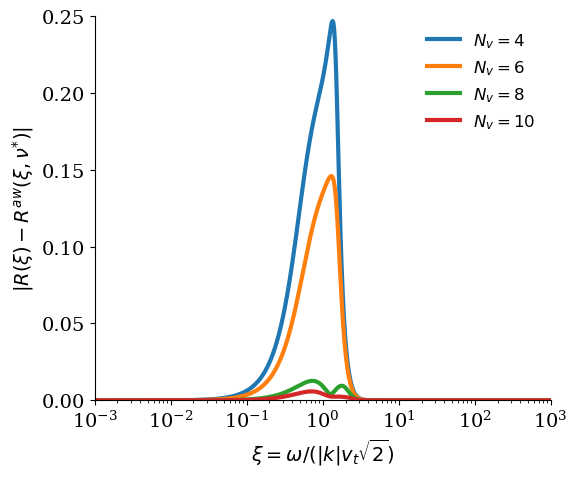

In [96]:
fig, ax = plt.subplots(figsize=(6, 5))

for nn in range(4, 11, 2):
    ax.plot(zeta, np.abs(R_true - R_Hermite_hyper(zeta, Nv=nn)), label=r"$N_{v} = " + str(nn) + "$", linewidth=3)

ax.set_ylim(0, 0.25)
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|R(\xi) - R^{aw}(\xi, \nu^{*})|$")
ax.set_xlabel(r"$\xi = \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xscale("log")
ax.set_xlim(1e-3, 1e3)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("figs/symbolic_response_function_AW_hypercollisons.png", dpi=200)

In [114]:
x = np.arange(4, 12, 2)
error_LB = np.zeros(len(x)) 
error_Hyper = np.zeros(len(x)) 
error_HP = np.zeros(len(x)) 

ii = 0
for nn in x:
    error_Hyper[ii] = np.linalg.norm(np.abs(R_true - R_Hermite_hyper(zeta, Nv=nn)))
    error_LB[ii] =  np.linalg.norm(np.abs(R_true - R_Hermite_LB(zeta, Nv=nn)))
    error_HP[ii] =  np.linalg.norm(np.abs(R_true - R_Hermite_HP(zeta, Nv=nn)))
    ii +=1

In [115]:
# find the best fitting linear slope 
a_hyper, b_hyper = np.polyfit(x, error_Hyper, 1)
a_lb, b_lb = np.polyfit(x, error_LB, 1)
a_hp, b_hp = np.polyfit(x, error_HP, 1)

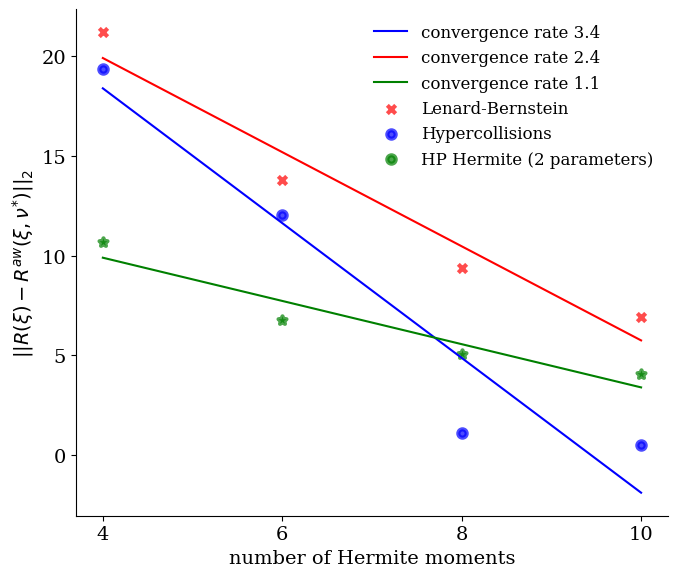

In [118]:
fig, ax = plt.subplots(figsize=(7, 6))


ax.scatter(x, error_Hyper, linewidth=3, alpha=0.7, color="blue")
ax.scatter(x, error_LB, linewidth=3, alpha=0.7, color="red", marker="x")
ax.scatter(x, error_HP, linewidth=3, alpha=0.7, color="green", marker="*")

ax.plot(x, a_hyper*x + b_hyper, color="blue", label="convergence rate " + str(round(np.abs(a_hyper), 1)))
ax.plot(x, a_lb*x + b_lb, color="red", label="convergence rate " + str(round(np.abs(a_lb), 1)))
ax.plot(x, a_hp*x + b_hp, color="green", label="convergence rate " + str(round(np.abs(a_hp), 1)))

ax.scatter(np.nan, np.nan, linewidth=3, alpha=0.7, color="red", marker="x", label="Lenard-Bernstein")
ax.scatter(np.nan, np.nan, linewidth=3, alpha=0.7, color="blue", label="Hypercollisions")
ax.scatter(np.nan, np.nan, linewidth=3, alpha=0.7, color="green", label="HP Hermite (2 parameters)")

ax.set_xticks([4, 6, 8, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$||R(\xi) - R^{aw}(\xi, \nu^{*})||_{2}$")
ax.set_xlabel(r"number of Hermite moments")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)

plt.tight_layout()
plt.savefig("figs/symbolic_response_function_AW_collisions_convergence.png", dpi=200)

## Landau damping dispersion relation

In [25]:
def get_landau_dispersion(func, xi_real, xi_imag, tol=1e-5):
    # initialize vectors 
    k_ = np.zeros(len(xi_real))*np.nan
    gr_ = np.zeros(len(xi_real))*np.nan
    # loop over to find minima
    for ii, xr in enumerate(xi_real):
        r_ = func(xi=xr + 1j*xi_imag) 
        if np.min(np.abs(np.imag(r_))) < tol:
            gr_[ii] = xi_imag[np.nanargmin(np.abs(r_.imag))]
            if r_[np.nanargmin(np.abs(np.imag(r_)))].real>=0:
                k_[ii] = np.sqrt(r_[np.nanargmin(np.abs(r_.imag))].real)
    return gr_[np.argsort(k_)], k_[np.argsort(k_)]

In [26]:
gr_true, k_true = get_landau_dispersion(func=R, xi_real=np.linspace(0, 5, int(1e4)), xi_imag=np.linspace(-1, 0, int(1e4)))

In [27]:
gr_hp3, k_hp3 = get_landau_dispersion(func=RHP3, xi_real=np.linspace(0, 7, int(1e4)), xi_imag=np.linspace(-0.8, 0, int(1e4)))

In [28]:
gr_hp4, k_hp4 = get_landau_dispersion(func=RHP4, xi_real=np.linspace(0, 6, int(1e4)), xi_imag=np.linspace(-0.75, 0, int(1e4)))

In [45]:
gr_l6, k_l6 = get_landau_dispersion(func=lambda xi: R4(xi, col=5), xi_real=np.linspace(0, 5, int(1e4)), xi_imag=np.linspace(-0.75, 0, int(1e4)), tol=5e-6)

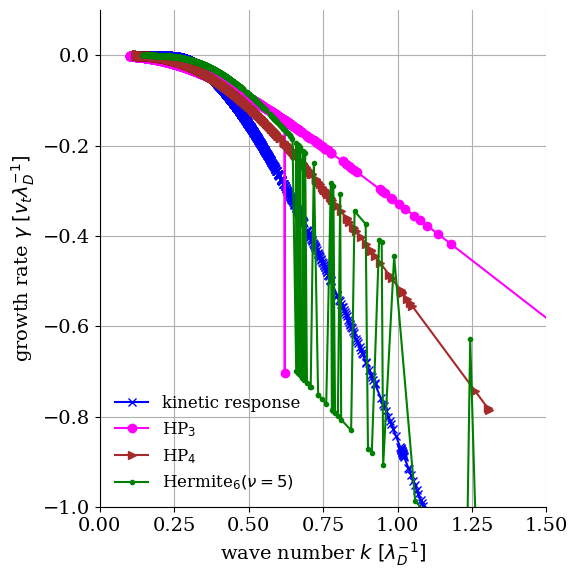

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(k_true, gr_true*np.sqrt(2)*k_true, label=r"kinetic response", c="blue", marker="x")
ax.plot(k_hp3,  gr_hp3*np.sqrt(2)*k_hp3, label=r"HP$_{3}$", c="magenta", marker="o")
ax.plot(k_hp4,  gr_hp4*np.sqrt(2)*k_hp4, label=r"HP$_{4}$", c="brown", marker=">")
ax.plot(k_l6,  gr_l6*np.sqrt(2)*k_l6, label=r"Hermite$_{6}(\nu=5)$ ", c="green", marker=".")

ax.set_ylabel(r"growth rate $\gamma$ $[v_{t}\lambda_{D}^{-1}]$")
ax.set_xlabel(r"wave number $k$ $[\lambda_{D}^{-1}]$")
ax.set_ylim(-1, 0.1)
ax.set_xlim(0, 1.5)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig("figs/landau_damping_hp_collisions.png", dpi=200)

## Bump-on-tail dispersion relation

In [53]:
# Despersion relation
def disp_k_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*R(xi=(xi-u2)) - (1-n1)*R(xi=((xi-u1)/T))

# Despersion relation
def disp_k_hp3_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*RHP3(xi=(xi-u2)) - (1-n1)*RHP3(xi=(xi-u1)/T)

# Despersion relation
def disp_k_hp4_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*RHP4(xi=(xi-u2)) -(1-n1)*RHP4(xi=(xi-u1)/T)

# Despersion relation
def disp_k_6_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*R6(xi=(xi-u2)) -(1-n1)*R6(xi=(xi-u1)/T)

In [54]:
gr_true, k_true = get_landau_dispersion(func=disp_k_bot, xi_real=np.linspace(1E-2, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [55]:
gr_hp3, k_hp3 = get_landau_dispersion(func=disp_k_hp3_bot, xi_real=np.linspace(0, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [56]:
gr_hp4, k_hp4 = get_landau_dispersion(func=disp_k_hp4_bot, xi_real=np.linspace(0, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [57]:
gr_l16, k_l16 = get_landau_dispersion(func=disp_k_6_bot, xi_real=np.linspace(0, 4, int(1e3)), xi_imag=np.linspace(0, 3, int(1e3)), tol=1e-3)

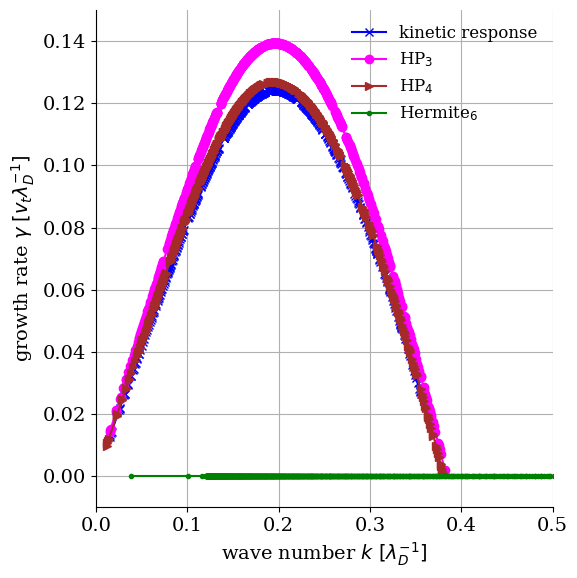

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(k_true, gr_true*np.sqrt(2)*k_true, label=r"kinetic response", c="blue", marker="x")
ax.plot(k_hp3,  gr_hp3*np.sqrt(2)*k_hp3, label=r"HP$_{3}$", c="magenta", marker="o")
ax.plot(k_hp4,  gr_hp4*np.sqrt(2)*k_hp4, label=r"HP$_{4}$", c="brown", marker=">")
ax.plot(k_l6,  gr_l6*np.sqrt(2)*k_l6, label=r"Hermite$_{6}$", c="green", marker=".")

ax.set_ylabel(r"growth rate $\gamma$ $[v_{t}\lambda_{D}^{-1}]$")
ax.set_xlabel(r"wave number $k$ $[\lambda_{D}^{-1}]$")
ax.set_ylim(-0.01, 0.15)
ax.set_xlim(0., 0.5)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig("figs/bump_on_tail_hp_collisions.png", dpi=200)